# Derive most distinguishing words per character

In [1]:
from __future__ import division
import glob
import codecs
import re
from collections import Counter
from collections import defaultdict
from heapq import nlargest

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from google.cloud import language

WORKING_DIRECTORY = "/Users/emersonsjsu/GitHub/EarlGrey"
%matplotlib inline


In [2]:
# Load words from scripts into wordcount dict
FIRST_EPISODE_OFFSET = 101
LAST_EPISODE_IN_SEASON = {25: 1, 47: 2, 73: 3, 99: 4, 125: 5, 151: 6, 176: 7}
regex = re.compile('[^a-zA-Z ]')


def get_season(episode_no):
    return LAST_EPISODE_IN_SEASON.get(episode_no, 0)


def sanitize_name(name_line):
    name = name_line.strip()  # Voice overs count as same character
    if name.endswith('V.O.'):
        name = name[:-5]
    # Strip parentheticals from name
    if name.find('(') != -1:
        name = name[:name.find('(')]
    # Strip 'S VOICE from name
    if name.endswith('\'S VOICE'):
        name = name[:-8]
    # Strip 'S COM VOICE from name
    if name.endswith('\'S COM VOICE'):
        name = name[:-12]
    return name.strip()


# counters_dict expects {char: (counter_obj, [s1count,s2count, ..., s7count])}
def process_script(file_path, counters_dict):
    current_file = codecs.open(file_path, "r", encoding='utf-8', errors="ignore")
    episode_no = int(current_file.name[current_file.name.rfind('/') + 1:-4]) - FIRST_EPISODE_OFFSET
    is_dialogue = False
    character_name = ""
    lines = current_file.readlines()
    for line in lines:
        # Character dialogue has ended, reset current character
        if line.strip() == '':
            is_dialogue = False
        # All names are preceded by exactly 5 tabs
        elif line[:5] == '\t\t\t\t\t' and line[5:6] != '\t' and not line.strip().startswith('('):
            # We have found a name! Update current name
            character_name = sanitize_name(line)
            is_dialogue = True
        # If we are still looking at a character's dialogue
        elif is_dialogue:
            # Update character's counter object
            counters_dict[character_name][0].update(regex.sub('', line).lower().split())
    current_file.close()

    # Check if we are end of a season
    season_no = get_season(episode_no)
    if season_no:
        # Update wc per season for each character in counters_dict
        for v in counters_dict.itervalues():
            # Set season wc for every character. Subtract sum of previous values because counter_obj
            # keeps cumulative word count
            v[1][season_no - 1] = sum(v[0].values()) - sum(v[1])


# character_wc_dict schema is {char: (counter_obj, [s1count,s2count, ..., s7count])}
character_wc_dict = defaultdict(lambda: (Counter(), [0] * 7))
# for full_path in sorted(glob.glob(WORKING_DIRECTORY+'/scripts/148.txt')):  # Only read one file for debug purposes
for full_path in sorted(glob.glob(WORKING_DIRECTORY + '/scripts/*.txt')):
    process_script(full_path, character_wc_dict)


### What are Picard's top 10 words and counts?

In [3]:
character_wc_dict['PICARD'][0].most_common(10)


[(u'the', 6768),
 (u'to', 6469),
 (u'you', 4236),
 (u'i', 3401),
 (u'a', 3207),
 (u'of', 2943),
 (u'is', 2215),
 (u'it', 2084),
 (u'and', 2049),
 (u'that', 1966)]

### How many words does Worf say in season 3?

In [4]:
character_wc_dict['WORF'][1][3]

5159

In [5]:
%%time
# Add all character's word counts to find count of every word over all seasons, regardless of character
universal_wc = reduce((lambda x, y: x + y), map(lambda x: x[0], character_wc_dict.itervalues()))


### How many times is the word 'Captain' said over all 7 seasons of Star Trek: TNG?

In [23]:
universal_wc['captain']

3888

In [24]:
# Extract most talkative 8 characters
char_total_wc = []
for k, v in character_wc_dict.iteritems():
    tup = sum(v[1]), k
    char_total_wc.append(tup)
main_character_wc = nlargest(8, char_total_wc, lambda x: x[0])
main_characters = [x[1] for x in main_character_wc]
main_character_wc


[(167521, u'PICARD'),
 (90119, u'DATA'),
 (80704, u'RIKER'),
 (59431, u'GEORDI'),
 (46019, u'BEVERLY'),
 (40324, u'TROI'),
 (37178, u'WORF'),
 (14631, u'WESLEY')]

### What are the most distinguishing words of main characters?

In [25]:
anyone_speaks = sum([x[0] for x in char_total_wc])
for person in main_characters:
    counter = character_wc_dict[person][0]
    person_speaks = [wc[0] for wc in main_character_wc if wc[1] == person][0]
    defining_wc = {}
    for word, count in counter.iteritems():
        defining_wc[word] = (count ** 1.3)/person_speaks / (universal_wc[word]/anyone_speaks)
    print(person)
    top_n = nlargest(10, defining_wc.iteritems(), lambda x: x[1])
    print([str(x[0]) for x in top_n])


PICARD
['number', 'mister', 'captains', 'log', 'stardate', 'supplemental', 'to', 'the', 'data', 'admiral']
DATA
['however', 'approximately', 'appears', 'correct', 'translating', 'am', 'sir', 'appear', 'lal', 'is']
RIKER
['soren', 'rice', 'minuet', 'strap', 'decompress', 'william', 'yuta', 'kazago', 'knockout', 'ramistat']
GEORDI
['reg', 'commodore', 'shipley', 'visors', 'yeah', 'bochra', 'leah', 'visor', 'logan', 'boobytrap']
BEVERLY
['ccs', 'nana', 'cortical', 'chilton', 'alyssa', 'stimulator', 'alissa', 'inoprovaline', 'dizziness', 'tissue']
TROI
['mother', 'ian', 'overbearing', 'repress', 'sensing', 'mmmhmm', 'ceramics', 'chandra', 'izmadi', 'lifeforce']
WORF
['hailed', 'uncloaking', 'alexander', 'kahless', 'incoming', 'battelh', 'adoptive', 'torva', 'luk', 'heghbat']
WESLEY
['mom', 'davies', 'repulser', 'activator', 'icospectrogram', 'custodian', 'rosseau', 'prixus', 'alans', 'sentrys']


### What are the most distinguishing words of main characters compared to other main characters?

In [26]:
any_main_character_speaks = sum([x[0] for x in main_character_wc])
main_characters_counter = Counter()
for person in main_characters:
    main_characters_counter.update(character_wc_dict[person][0])
for person in main_characters:
    counter = character_wc_dict[person][0]
    person_speaks = [wc[0] for wc in main_character_wc if wc[1] == person][0]
    defining_wc = {}
    for word, count in counter.iteritems():
        defining_wc[word] = (count ** 1.3)/person_speaks / (main_characters_counter[word]/any_main_character_speaks)
    print(person)
    top_n = nlargest(8, defining_wc.iteritems(), lambda x: x[1])
    print([str(x[0]) for x in top_n])


PICARD
['number', 'mister', 'captains', 'to', 'you', 'log', 'the', 'stardate']


DATA
['am', 'approximately', 'however', 'correct', 'is', 'sir', 'appears', 'the']
RIKER
['william', 'yuta', 'soren', 'to', 'minuet', 'kazago', 'rice', 'the']
GEORDI
['yeah', 'hey', 'reg', 'leah', 'okay', 'gonna', 'guy', 'bochra']
BEVERLY
['ccs', 'nurse', 'tissue', 'nana', 'stimulator', 'symptoms', 'cerebral', 'dizziness']
TROI
['mother', 'isabella', 'clara', 'shiar', 'tal', 'nvek', 'hedril', 'ian']
WORF
['warrior', 'kahless', 'alexander', 'hailed', 'warriors', 'molor', 'koroth', 'dishonor']
WESLEY
['mom', 'custodian', 'nick', 'mordock', 'davies', 'josh', 'repulser', 'activator']


## Visualize generated information

In [27]:
# Plot character's total words per season
for person in main_characters:
    box_fig = plt.figure('%s words over seasons' % person)
    plt.bar(range(1, 8), character_wc_dict[person][1])
    plt.xlabel('Season')
    plt.ylabel('Number of words said')
    plt.title('%s\'s words said over the 7 seasons of TNG' % person)
    box_fig.show()


In [28]:
# Plot total words per season
wc_per_season = reduce(lambda x, y: [sum(pair) for pair in zip(x,y)], map(lambda x: x[1], character_wc_dict.itervalues()))
plt.bar(range(1,8), wc_per_season)
plt.xlabel('Season')
plt.ylabel('Number of words said')
plt.title('Total words said over the 7 seasons of TNG')
plt.show()


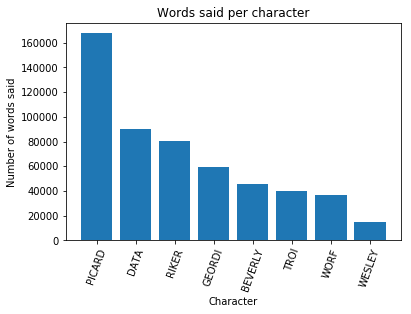

In [35]:
plt.figure('wc_per_char')
plt.bar(range(len(main_character_wc)), [x[0] for x in main_character_wc])
plt.xlabel('Character')
plt.ylabel('Number of words said')
plt.xticks(range(len(main_character_wc)), [x[1] for x in main_character_wc])
plt.xticks(rotation=70)
plt.title('Words said per character')
plt.show()


In [30]:
COLORS = ['#FF9900', '#CC99CC', '#9999CC', '#CC6666', '#FFCC99',
          '#9999FF', '#FF9966', '#CC6699']
ALPHA = 100
for idx, wc_tuple in enumerate(main_character_wc):
    fig = plt.figure(figsize=(.75, 2))
    ax = fig.add_subplot(111)
    count = wc_tuple[0]
    character = wc_tuple[1]
    ax.bar(0, count, color=COLORS[idx % len(COLORS)])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_ylim(0, max([x[0] for x in main_character_wc]))
    ax.set_xticks([], False)
    ax.set_yticks([], False)
    plt.show()
    fig.savefig(character+'_total', transparent=True)


In [31]:
# Plot character's total words per season
for idx, person in enumerate(main_characters):
    fig = plt.figure(figsize=(9, 3))
    ax = fig.add_subplot(111)
    ax.bar(range(1, 8), character_wc_dict[person][1], color=COLORS[idx % len(COLORS)])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([], False)
    ax.set_yticks([], False)
    plt.show()
    fig.savefig(person+'_by_season', transparent=True)


In [32]:
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
ax.bar(range(len(main_character_wc)), [x[0] for x in main_character_wc], color=COLORS)
plt.yticks(np.arange(0, 170001, 170000/2))
ax.tick_params(axis='y', colors='#FF9900', labelleft=False)
ax.set_xticks([], False)
#ax.set_yticks([], False)
ax.xaxis.set_tick_params(width=3)
ax.yaxis.set_tick_params(width=3)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color('#FF9900')
plt.show()
fig.savefig('words_per_character', transparent=True)

In [33]:
# Plot total words per season
wc_per_season = reduce(lambda x, y: [sum(pair) for pair in zip(x,y)], map(lambda x: x[1], character_wc_dict.itervalues()))
fig = plt.figure(figsize=(4.5, 1.5))
ax = fig.add_subplot(111)
ax.bar(range(1,8), wc_per_season, color=['#FF9900'])
ax.tick_params(axis='x', colors='#FF9900', labelbottom=False)
ax.set_xticks([], True)
ax.set_yticks([], False)
ax.xaxis.set_tick_params(width=3)
ax.yaxis.set_tick_params(width=3)
ax.spines['bottom'].set_linewidth(3)
ax.spines['bottom'].set_color('#FF9900')
for axis in ['right', 'top', 'left']:
    ax.spines[axis].set_visible(False)
plt.show()
fig.savefig('words_per_season', transparent=True)
